In [115]:
import scanpy as sc 
import torch
import matplotlib.pyplot as plt
import os
from harmony import harmonize
import scib
import numpy as np
import anndata as ad
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
os.system("clear")

###############
dataset="human_pancreas_norm_complexBatch"
###############

data_dir="/goofys/users/Aleksandra_S/benchmarking_datasets/"+dataset+".h5ad"
adata_raw=ad.read_h5ad(data_dir)
adata_raw.obs['batch'] = adata_raw.obs.tech
# print_dataset_information(adata_raw,batch_key="BATCH",celltype_key="celltype")

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages

## scib funkcije

In [89]:
adata_scib = adata_raw.copy()

In [90]:


def split_batches(adata, batch, hvg=None, return_categories=False):
    """Split batches and preserve category information

    :param adata:
    :param batch: name of column in ``adata.obs``. The data type of the column must be of ``Category``.
    :param hvg: list of highly variable genes
    :param return_categories: whether to return the categories object of ``batch``
    """
    split = []
    batch_categories = adata.obs[batch].cat.categories
    if hvg is not None:
        adata = adata[:, hvg]
    for i in batch_categories:
        split.append(adata[adata.obs[batch] == i].copy())
    if return_categories:
        return split, batch_categories
    return split


def merge_adata(*adata_list, **kwargs):
    """Merge adatas from list while remove duplicated ``obs`` and ``var`` columns

    :param adata_list: ``anndata`` objects to be concatenated
    :param kwargs: arguments to be passed to ``anndata.AnnData.concatenate``
    """

    if len(adata_list) == 1:
        return adata_list[0]

    # Make sure that adatas do not contain duplicate columns
    for _adata in adata_list:
        for attr in ("obs", "var"):
            df = getattr(_adata, attr)
            dup_mask = df.columns.duplicated()
            if dup_mask.any():
                print(
                    f"Deleting duplicated keys `{list(df.columns[dup_mask].unique())}` from `adata.{attr}`."
                )
                setattr(_adata, attr, df.loc[:, ~dup_mask])

    return ad.AnnData.concatenate(*adata_list, **kwargs)


In [91]:

def scale_batch(adata, batch):
    """Batch-aware scaling of count matrix

    Scaling counts to a mean of 0 and standard deviation of 1 using ``scanpy.pp.scale`` for each batch separately.

    :param adata: ``anndata`` object with normalised and log-transformed counts
    :param batch: ``adata.obs`` column
    """

    # utils.check_adata(adata)
    # utils.check_batch(batch, adata.obs)

    # Store layers for after merge (avoids vstack error in merge)
    adata_copy = adata.copy()
    tmp = dict()
    for lay in list(adata_copy.layers):
        tmp[lay] = adata_copy.layers[lay]
        del adata_copy.layers[lay]

    split = split_batches(adata_copy, batch)

    for i in split:
        sc.pp.scale(i)

    adata_scaled = merge_adata(*split, batch_key=batch, index_unique=None)
    # Reorder to original obs_name ordering
    adata_scaled = adata_scaled[adata.obs_names]

    # Add layers again
    for key in tmp:
        adata_scaled.layers[key] = tmp[key]

    del tmp
    del adata_copy

    return adata_scaled

In [92]:


def hvg_intersect(
    adata,
    batch,
    target_genes=2000,
    flavor="cell_ranger",
    n_bins=20,
    adataOut=False,
    n_stop=8000,
    min_genes=500,
    step_size=1000,
):
    """Highly variable gene selection

    Legacy approach to HVG selection only using HVG intersections between all batches

    :param adata: ``anndata`` object with preprocessed counts
    :param batch: ``adata.obs`` column
    :param target_genes: maximum number of genes (intersection reduces the number of genes)
    :param min_genes: minimum number of intersection HVGs targeted
    :param step_size: step size to increase HVG selection per dataset
    :return: list of maximal ``target_genes`` number of highly variable genes
    """

    # utils.check_adata(adata)
    # utils.check_batch(batch, adata.obs)

    intersect = None
    enough = False
    n_hvg = target_genes

    split = split_batches(adata, batch)
    hvg_res = []

    for i in split:
        sc.pp.filter_genes(
            i, min_cells=1
        )  # remove genes unexpressed (otherwise hvg might break)
        hvg_res.append(
            sc.pp.highly_variable_genes(
                i, flavor=flavor, n_top_genes=n_hvg, n_bins=n_bins, inplace=False
            )
        )

    while not enough:
        genes = []

        for i in range(len(split)):
            dispersion_norm = hvg_res[i]["dispersions_norm"]
            dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
            dispersion_norm[::-1].sort()
            disp_cut_off = dispersion_norm[n_hvg - 1]
            gene_subset = np.nan_to_num(hvg_res[i]["dispersions_norm"]) >= disp_cut_off

            genes.append(set(split[i].var[gene_subset].index))

        intersect = genes[0].intersection(*genes[1:])
        if len(intersect) >= target_genes:
            enough = True
        else:
            if n_hvg > n_stop:
                if len(intersect) < min_genes:
                    raise Exception(
                        f"Only {len(intersect)} HVGs were found in the intersection.\n"
                        f"This is fewer than {min_genes} HVGs set as the minimum.\n"
                        "Consider raising `n_stop` or reducing `min_genes`."
                    )
                break
            n_hvg = int(n_hvg + step_size)

    if adataOut:
        return adata[:, list(intersect)].copy()

    return list(intersect)

In [93]:
def hvg_batch(
    adata,
    batch_key=None,
    target_genes=2000,
    flavor="cell_ranger",
    n_bins=20,
    adataOut=False,
):
    """Batch-aware highly variable gene selection

    Method to select HVGs based on mean dispersions of genes that are highly
    variable genes in all batches. Using a the top target_genes per batch by
    average normalize dispersion. If target genes still hasn't been reached,
    then HVGs in all but one batches are used to fill up. This is continued
    until HVGs in a single batch are considered.

    :param adata: ``anndata`` object
    :param batch: ``adata.obs`` column
    :param target_genes: maximum number of genes (intersection reduces the number of genes)
    :param flavor: parameter for ``scanpy.pp.highly_variable_genes``
    :param n_bins: parameter for ``scanpy.pp.highly_variable_genes``
    :param adataOut: whether to return an ``anndata`` object or a list of highly variable genes
    """

    # utils.check_adata(adata)
    # if batch_key is not None:
    #     utils.check_batch(batch_key, adata.obs)

    adata_hvg = adata if adataOut else adata.copy()

    n_batches = len(adata_hvg.obs[batch_key].cat.categories)

    # Calculate double target genes per dataset
    sc.pp.highly_variable_genes(
        adata_hvg,
        flavor=flavor,
        n_top_genes=target_genes,
        n_bins=n_bins,
        batch_key=batch_key,
    )

    nbatch1_dispersions = adata_hvg.var["dispersions_norm"][
        adata_hvg.var.highly_variable_nbatches
        > len(adata_hvg.obs[batch_key].cat.categories) - 1
    ]

    nbatch1_dispersions.sort_values(ascending=False, inplace=True)

    if len(nbatch1_dispersions) > target_genes:
        hvg = nbatch1_dispersions.index[:target_genes]

    else:
        enough = False
        print(f"Using {len(nbatch1_dispersions)} HVGs from full intersect set")
        hvg = nbatch1_dispersions.index[:]
        not_n_batches = 1

        while not enough:
            target_genes_diff = target_genes - len(hvg)

            tmp_dispersions = adata_hvg.var["dispersions_norm"][
                adata_hvg.var.highly_variable_nbatches == (n_batches - not_n_batches)
            ]

            if len(tmp_dispersions) < target_genes_diff:
                print(
                    f"Using {len(tmp_dispersions)} HVGs from n_batch-{not_n_batches} set"
                )
                hvg = hvg.append(tmp_dispersions.index)
                not_n_batches += 1

            else:
                print(
                    f"Using {target_genes_diff} HVGs from n_batch-{not_n_batches} set"
                )
                tmp_dispersions.sort_values(ascending=False, inplace=True)
                hvg = hvg.append(tmp_dispersions.index[:target_genes_diff])
                enough = True

    print(f"Using {len(hvg)} HVGs")

    if not adataOut:
        del adata_hvg
        return hvg.tolist()
    else:
        return adata_hvg[:, hvg].copy()

In [94]:
hvgs = hvg_batch(
    adata_scib,
    batch_key='batch',
    target_genes=2000,
    flavor="cell_ranger",
    n_bins=20,
    adataOut=False
)

Using 65 HVGs from full intersect set
Using 221 HVGs from n_batch-1 set
Using 274 HVGs from n_batch-2 set
Using 269 HVGs from n_batch-3 set
Using 349 HVGs from n_batch-4 set
Using 435 HVGs from n_batch-5 set
Using 387 HVGs from n_batch-6 set
Using 2000 HVGs


In [95]:
adata_scaled = scale_batch(adata_scib, 'batch')

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [96]:
adata_scaled

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'batch'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'mean-3', 'std-3', 'mean-4', 'std-4', 'mean-5', 'std-5', 'mean-6', 'std-6', 'mean-7', 'std-7', 'mean-8', 'std-8'
    layers: 'counts'

In [105]:
adata_scaled_total = sc.pp.scale(adata_scaled, copy=True)

In [106]:
scib.integration.harmony(adata_scaled_total, batch='batch', hvg=hvgs)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'batch'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'mean-3', 'std-3', 'mean-4', 'std-4', 'mean-5', 'std-5', 'mean-6', 'std-6', 'mean-7', 'std-7', 'mean-8', 'std-8', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca', 'X_emb'
    varm: 'PCs'
    layers: 'counts'

In [109]:
scib.metrics.ilisi_graph(adata_scaled, batch_key="batch", type_="embed", use_rep="X_emb")  # scib hvg_batch and scale_batch: 0.34785711430165206

0.34785711430165206

In [108]:
scib.metrics.ilisi_graph(adata_scaled_total, batch_key="batch", type_="embed", use_rep="X_emb")  # scib hvg_batch + scale_batch + scale: 0.363913464261448

0.363913464261448

In [104]:
scib.metrics.ilisi_graph(adata_scib, batch_key="batch", type_="embed", use_rep="X_emb")  # scib hvg_batch: 0.31892274345422367

0.31892274345422367

## scib end

komentar: pancreas dataset je normalizovan.
u counts layeru se nalaze raw counts vrv.

Harmony is an algorithm for integrating single-cell data from multiple experiments. This function uses the python port of Harmony, harmonypy, to integrate single-cell data stored in an AnnData object. As Harmony works by adjusting the principal components, this function should be run after performing PCA but before computing the neighbor graph, as illustrated in the example below.

## Raw dataset visualization

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

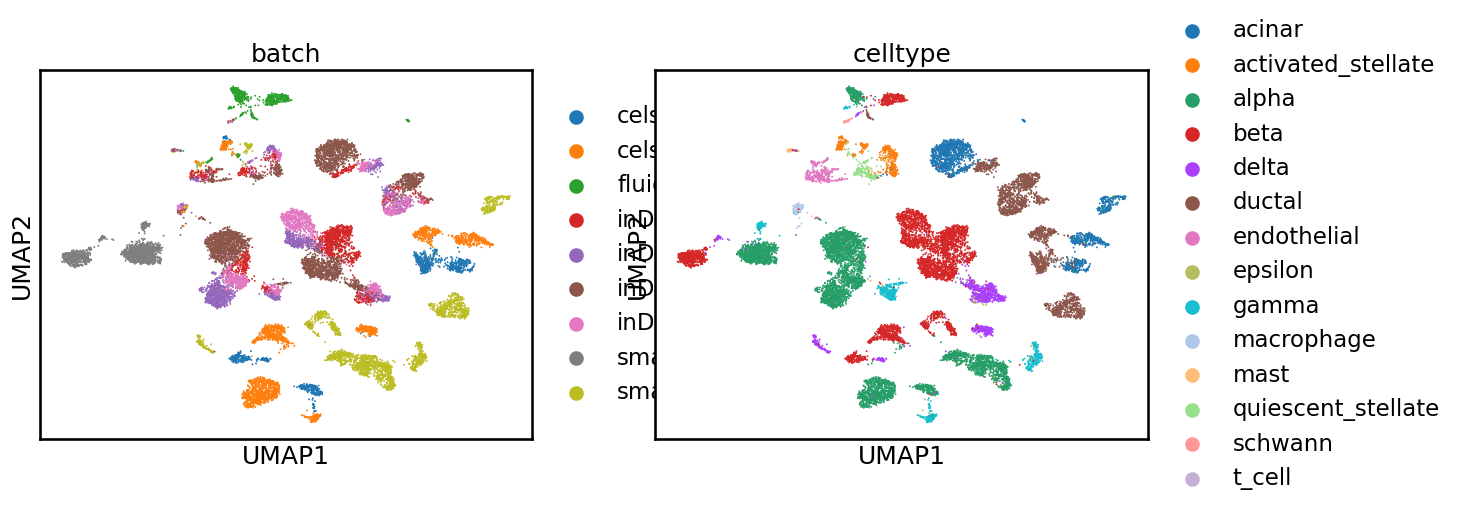

In [50]:
adata_copy=adata_raw.copy()
sc.pp.normalize_total(adata_copy,target_sum=1e4)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=2000)
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)
adata_harmony_ready = adata_copy
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy,color=["batch","celltype"],show=False)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

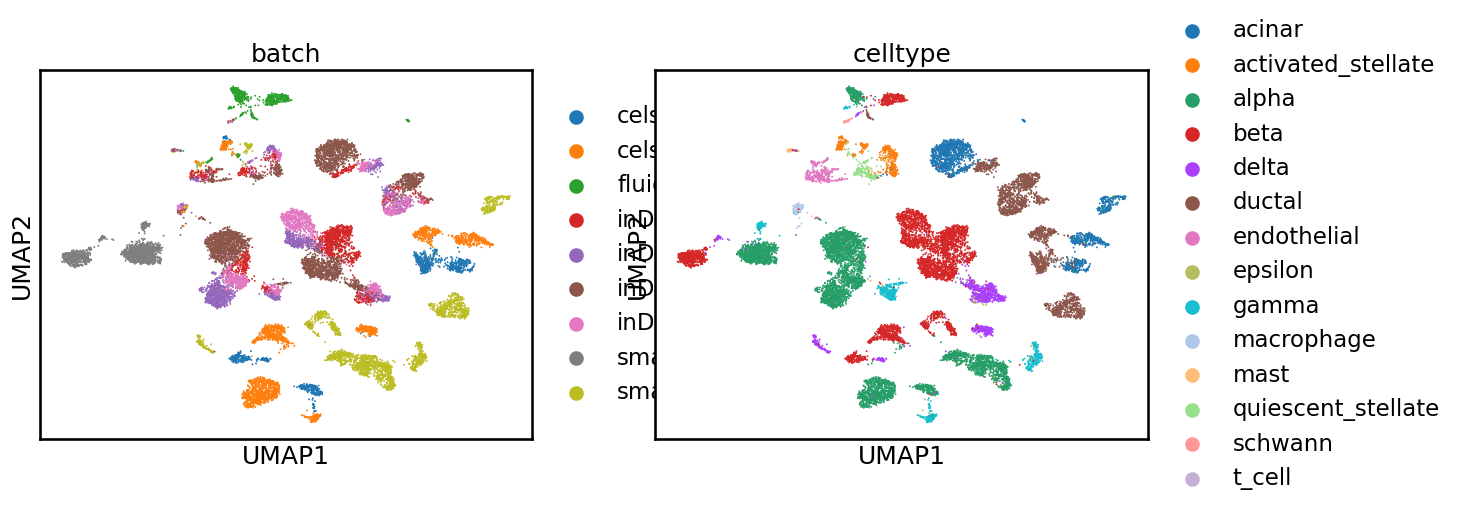

In [51]:
adata_copy=adata_raw.copy()
sc.pp.normalize_total(adata_copy,target_sum=1e4)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=2000)
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)
adata_harmony_ready = adata_copy
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy,color=["batch","celltype"],show=False)

## Harmony integration - no preprocessing

In [116]:
sc.pp.normalize_total(adata_raw,target_sum=1e4)
sc.pp.log1p(adata_raw)
sc.pp.highly_variable_genes(adata_raw,n_top_genes=2000, batch_key='batch')
# sc.pp.scale(adata_raw)
# scale by batch
adata_sep=[]
for batch in np.unique(adata_raw.obs['batch']):
    sep_batch=adata_raw[adata_raw.obs['batch']==batch].copy()
    sc.pp.scale(sep_batch)
    adata_sep.append(sep_batch)
adata_raw=sc.AnnData.concatenate(*adata_sep)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [117]:
sc.pp.scale(adata_raw)
sc.tl.pca(adata_raw, n_comps=20)

In [118]:
adata_raw.obsm["X_emb"] = harmonize(adata_raw.obsm["X_pca"], adata_raw.obs, batch_key='batch')

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [119]:
scib.metrics.ilisi_graph(adata_raw, batch_key="batch", type_="embed", use_rep="X_emb"
    # ,k0=15,
    # subsample=None,
    # scale=True,
    # n_cores=1
    )
# za sve ispod podrazumeva se da je radjen pca na kraju
# harmonize uradjen samo scale po batch-u: 0.3923750488790615
# harmonize uradjen samo ceo scale: 0.31522733099095085
# harmonize uradjeni samo hvg-ovi: 0.3991473824544036
# harmonize nista: 0.34752225894967603 
# harmonize hvg + scale po batchu: 0.4106796109510935
# harmonize hvg + scale: 0.3747757365161565
# harmonize hvg + scale po batchu + scale: 0.4142298486783158
# harmonize + norm_total + scale po batchu + scale: 0.393994900344913
# harmonize + norm_total + log1p + scale po batchu + scale: 0.39624105181194924

Chunk 664 does not have enough neighbors. Skipping...
Chunk 862 does not have enough neighbors. Skipping...
Chunk 865 does not have enough neighbors. Skipping...
Chunk 3511 does not have enough neighbors. Skipping...
Chunk 5828 does not have enough neighbors. Skipping...
Chunk 5845 does not have enough neighbors. Skipping...
Chunk 7005 does not have enough neighbors. Skipping...
Chunk 7013 does not have enough neighbors. Skipping...
Chunk 8029 does not have enough neighbors. Skipping...
Chunk 8119 does not have enough neighbors. Skipping...
Chunk 8251 does not have enough neighbors. Skipping...
Chunk 8311 does not have enough neighbors. Skipping...
Chunk 8320 does not have enough neighbors. Skipping...
Chunk 8744 does not have enough neighbors. Skipping...
Chunk 8786 does not have enough neighbors. Skipping...
Chunk 9072 does not have enough neighbors. Skipping...
Chunk 9116 does not have enough neighbors. Skipping...
Chunk 9209 does not have enough neighbors. Skipping...
Chunk 9624 do

0.39624105181194924

In [37]:
adata_raw_scib = adata_raw.copy()

In [14]:
# scib.integration.harmony(adata_raw_scib, batch='batch', hvg=list(adata_raw.var[adata_raw.var.highly_variable].index.values))

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_emb'
    varm: 'PCs'
    layers: 'counts'

In [15]:
scib.metrics.ilisi_graph(adata_raw_scib, batch_key="batch", type_="embed", use_rep="X_emb"
    # ,k0=15,
    # subsample=None,
    # scale=True,
    # n_cores=1
    )

Chunk 3760 does not have enough neighbors. Skipping...
Chunk 3846 does not have enough neighbors. Skipping...
Chunk 6165 does not have enough neighbors. Skipping...
Chunk 6247 does not have enough neighbors. Skipping...
Chunk 6248 does not have enough neighbors. Skipping...
Chunk 6249 does not have enough neighbors. Skipping...
Chunk 6250 does not have enough neighbors. Skipping...
Chunk 6251 does not have enough neighbors. Skipping...
Chunk 6252 does not have enough neighbors. Skipping...
Chunk 6253 does not have enough neighbors. Skipping...
Chunk 6254 does not have enough neighbors. Skipping...
Chunk 6255 does not have enough neighbors. Skipping...
Chunk 6256 does not have enough neighbors. Skipping...
Chunk 6257 does not have enough neighbors. Skipping...
Chunk 6258 does not have enough neighbors. Skipping...
Chunk 6259 does not have enough neighbors. Skipping...
Chunk 6260 does not have enough neighbors. Skipping...
Chunk 6261 does not have enough neighbors. Skipping...
Chunk 6262

0.3522445225919717

In [9]:
scib.metrics.ilisi_graph(adata_raw_scib, batch_key="batch", type_="embed", use_rep="X_emb"
    ,k0=5000,
    # subsample=None,
    # scale=True,
    # n_cores=1
    )

Chunk 664 does not have enough neighbors. Skipping...
Chunk 1937 does not have enough neighbors. Skipping...
Chunk 2178 does not have enough neighbors. Skipping...
Chunk 3511 does not have enough neighbors. Skipping...
Chunk 5828 does not have enough neighbors. Skipping...
Chunk 5845 does not have enough neighbors. Skipping...
Chunk 7005 does not have enough neighbors. Skipping...
Chunk 7013 does not have enough neighbors. Skipping...
Chunk 8029 does not have enough neighbors. Skipping...
Chunk 8119 does not have enough neighbors. Skipping...
Chunk 8251 does not have enough neighbors. Skipping...
Chunk 8311 does not have enough neighbors. Skipping...
Chunk 8320 does not have enough neighbors. Skipping...
Chunk 8358 does not have enough neighbors. Skipping...
Chunk 8744 does not have enough neighbors. Skipping...
Chunk 8786 does not have enough neighbors. Skipping...
Chunk 9072 does not have enough neighbors. Skipping...
Chunk 9116 does not have enough neighbors. Skipping...
Chunk 9209 

0.6734564621525103

### proba end

In [36]:
# sc.pp.normalize_total(adata_raw,target_sum=1e4)
# sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
sc.tl.pca(adata_raw, n_comps=20)
adata_raw.obsm["X_emb"] = harmonize(adata_raw.obsm["X_pca"], adata_raw.obs, batch_key='batch')

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

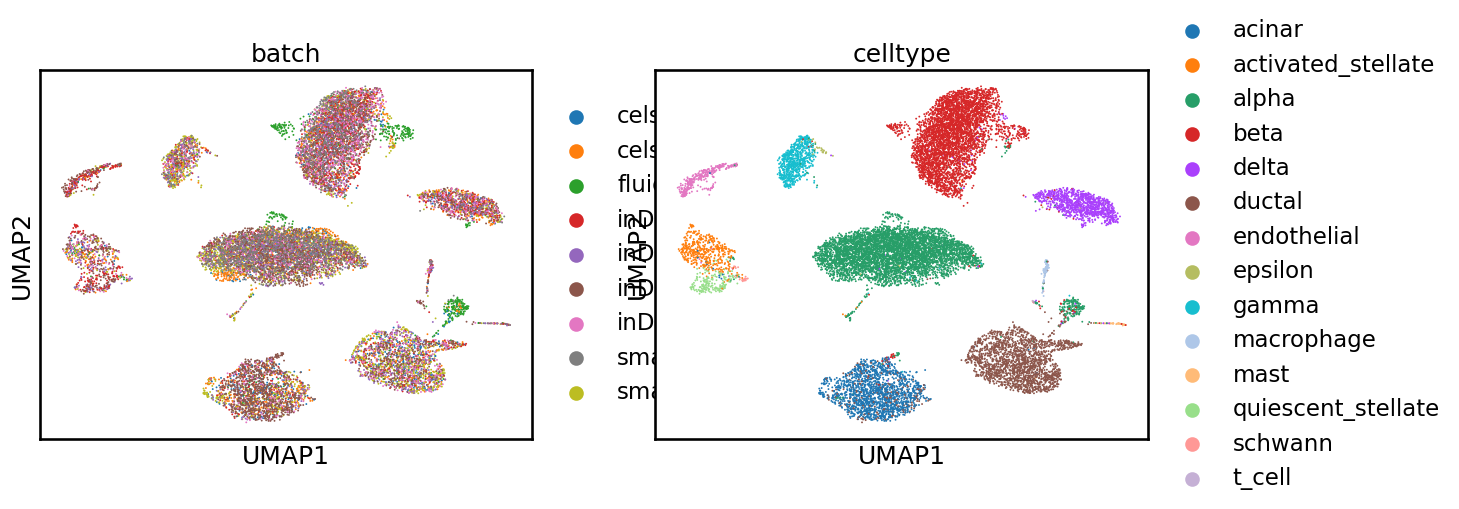

In [37]:
###########################################
sc.pp.neighbors(adata_raw,random_state=0,use_rep="X_emb")
sc.tl.umap(adata_raw)
###########################################

sc.pl.umap(adata_raw,color=["batch", "celltype"],show=False)
#plt.savefig(save_dir+"scDML_embedding1.png")


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'reassign_cluster'}, xlabel='UMAP1', ylabel='UMAP2'>]

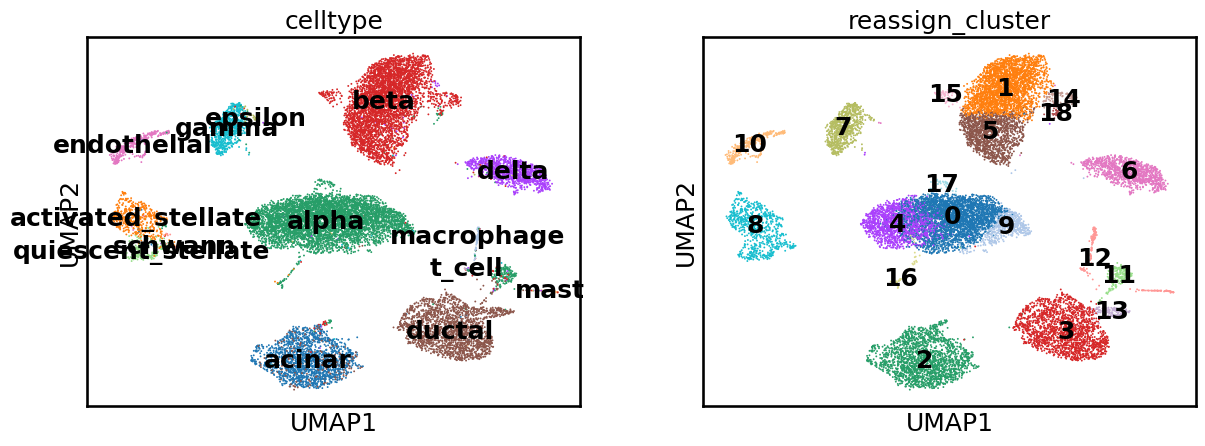

In [38]:
adata_clustering  = adata_raw.copy()
sc.tl.louvain(adata_clustering,resolution=1,key_added="louvain")
adata_raw.obs["reassign_cluster"] = adata_clustering.obs.louvain

sc.pl.umap(adata_raw,color=["celltype","reassign_cluster"],legend_loc="on data",show=False)

In [39]:
ari=adjusted_rand_score(adata_raw.obs["reassign_cluster"],adata_raw.obs["celltype"])
nmi=normalized_mutual_info_score(adata_raw.obs["reassign_cluster"],adata_raw.obs["celltype"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.5946923338912208
NMI=0.7796751499775038


In [48]:
scib.metrics.ilisi_graph(adata_raw, batch_key="batch", type_="embed", use_rep="X_emb"
    # ,k0=15,
    # subsample=None,
    # scale=True,
    # n_cores=1
    )

0.3754231342593335

In [44]:
scib.metrics.nmi(adata_raw, cluster_key='reassign_cluster', label_key='celltype', implementation='arithmetic')

0.7796751499775038

In [46]:
scib.metrics.ari(adata_raw, cluster_key='reassign_cluster', label_key='celltype', implementation=None)

0.5946923338912207

In [51]:
scib.metrics.silhouette(adata_raw, label_key='reassign_cluster', embed= 'X_emb', metric='euclidean', scale=True)

0.6396288871765137

In [17]:
scib.me.ilisi_graph(adata_raw, batch_key="batch", type_="embed", use_rep="X_pca")

0.003961113727997595

# Harmony integration - preprocessing

In [17]:
adata_copy=adata_raw.copy()
sc.pp.normalize_total(adata_copy,target_sum=1e4)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=2000,subset=True)
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)
adata_harmony_ready = adata_copy

In [3]:
adata_harmony_ready

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [4]:
adata_harmony_ready.obsm["X_emb"] = harmonize(adata_harmony_ready.obsm["X_pca"], adata_harmony_ready.obs, batch_key='batch')

	Initialization is completed.
	Completed 1 / 10 iteration(s).


	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

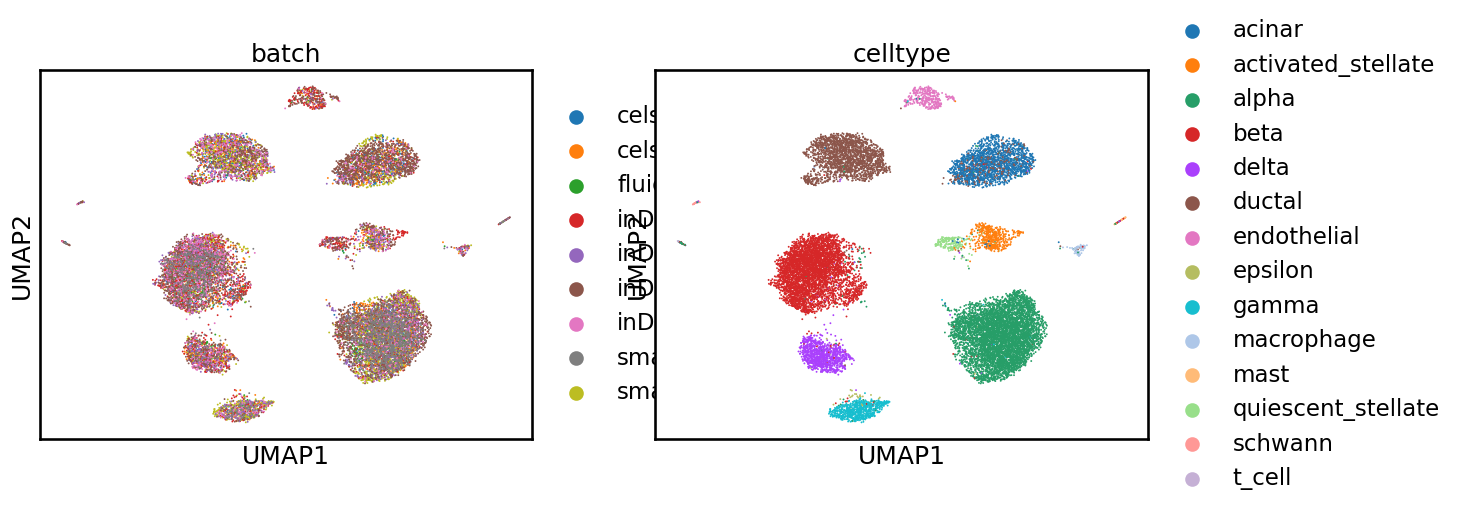

In [5]:
###########################################
sc.pp.neighbors(adata_harmony_ready,random_state=0,use_rep="X_emb")
sc.tl.umap(adata_harmony_ready)
###########################################

sc.pl.umap(adata_harmony_ready,color=["batch", "celltype"],show=False)
#plt.savefig(save_dir+"scDML_embedding1.png")


In [7]:
adata_clustering  = adata_harmony_ready.copy()
sc.tl.louvain(adata_clustering,resolution=1,key_added="louvain")
adata_harmony_ready.obs["reassign_cluster"] = adata_clustering.obs.louvain

In [8]:
ari=adjusted_rand_score(adata_harmony_ready.obs["reassign_cluster"],adata_harmony_ready.obs["celltype"])
nmi=normalized_mutual_info_score(adata_harmony_ready.obs["reassign_cluster"],adata_harmony_ready.obs["celltype"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.6893374631811051
NMI=0.8272817821152867


In [11]:
adata_clustering  = adata_harmony_ready.copy()
sc.tl.louvain(adata_clustering,resolution=0.5,key_added="louvain")
adata_harmony_ready.obs["reassign_cluster"] = adata_clustering.obs.louvain
ari=adjusted_rand_score(adata_harmony_ready.obs["reassign_cluster"],adata_harmony_ready.obs["celltype"])
nmi=normalized_mutual_info_score(adata_harmony_ready.obs["reassign_cluster"],adata_harmony_ready.obs["celltype"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.947742845115318
NMI=0.9137335573664184


In [16]:
adata_clustering  = adata_harmony_ready.copy()
sc.tl.louvain(adata_clustering,resolution=0.1,key_added="louvain")
adata_harmony_ready.obs["reassign_cluster"] = adata_clustering.obs.louvain
ari=adjusted_rand_score(adata_harmony_ready.obs["reassign_cluster"],adata_harmony_ready.obs["celltype"])
nmi=normalized_mutual_info_score(adata_harmony_ready.obs["reassign_cluster"],adata_harmony_ready.obs["celltype"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.9463563163997043
NMI=0.9107211092773316


In [9]:
scib.me.ilisi_graph(adata_harmony_ready, batch_key="batch", type_="embed", use_rep="X_emb")

0.35968818762918287

In [13]:
scib.me.clisi_graph(adata_harmony_ready, label_key="celltype", type_="embed", use_rep="X_emb")

1.0